## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import dgl
from dgl.nn.pytorch import GraphConv
from networkx.algorithms import approximation as approx

import random
import math
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict, defaultdict
from itertools import chain, islice, combinations
from time import time

## Seeding

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


## Graph Generation

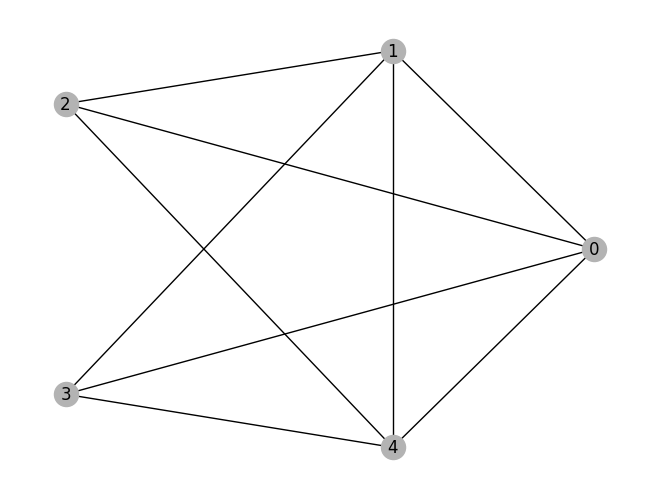

In [3]:
# Generate random graph of specified size and type,
# with specified degree (d) or edge probability (p)
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].
    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.OrderedGraph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    return nx_graph
    
def gen_graph(n):
    #Genereate tree as base for final graph
    G_temp = nx.random_tree(n, seed=42)
    
    #Number of edges in addition graph
    k = math.sqrt(n)/2
    
    #Fill in tree with new edges
    G_temp.add_edges_from(nx.gnm_random_graph(n, n-1+k, seed=42).edges())

    G = nx.Graph()
    G.add_nodes_from(sorted(G_temp.nodes()))
    G.add_edges_from(G_temp.edges)
    #Display the graph
#     draw_graph(G, [])
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=[[.7, .7, .7]])
    plt.show()
    
    return G

def draw_graph(G, subset):
    # Create dictionary of colors based on set membership
    node_colors = ['red' if node in subset else 'blue' for node in G.nodes()]
    
    # Draw nodes, edges, and labels
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    
    # Display graph
    plt.show()

Graph = gen_graph(5)

## Q-Matrix

### Generate Q-Matrix

In [4]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic

### Convert Q Matrix to Tensor

In [5]:
# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.
    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat

## Graph Convolutional Network

In [6]:
# GNN class to be instantiated with specified param values
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.
        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.
        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h

### Loss Function

In [7]:
# helper function for custom loss according to Q matrix
def loss_func(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.
    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    return cost

## Helper functions

In [8]:
# Chunk long list
def gen_combinations(combs, chunk_size):
    yield from iter(lambda: list(islice(combs, chunk_size)), [])

## Instantiating the Model

In [9]:
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.
    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

## Running Training

In [10]:
# Parent function to run GNN training given input config
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring

## Running

In [11]:
# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = approx.maximum_independent_set(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve

# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

In [12]:
def run_network(nx_graph):
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    
    # Visualize graph
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])
    
    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 1,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    # For tracking hyperparameters in results object
    gnn_hypers.update(opt_params)
    
    print('Running GNN...')
    gnn_start = time()

    _, epoch, final_bitstring, best_bitstring = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

    gnn_time = time() - gnn_start
    
    final_loss = loss_func(final_bitstring.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in final_bitstring])

    print('-----------------------------------------------------------------------------------')
    # Process bitstring reported by GNN
    size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')
    
    # Visualize result
    # Note no light-blue nodes are connected by an edge
    color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
    nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)
    
    # run solver
    print('-----------------------------------------------------------------------------------')
    print(f'Running built-in MIS solver (n={n}).')
    start = time()
    ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
    end = time()
    runtime_sol = end - start
    print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
    print(f'MIS solver took {round(runtime_sol, 3)}s')
    
    return best_bitstring

Generating d-regular graph with n=100, d=3, seed=1


C:\Users\Hayden\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: OrderedGraph is deprecated and will be removed in version 3.0.
Use `Graph` instead, which guarantees order is preserved for
Python >= 3.7



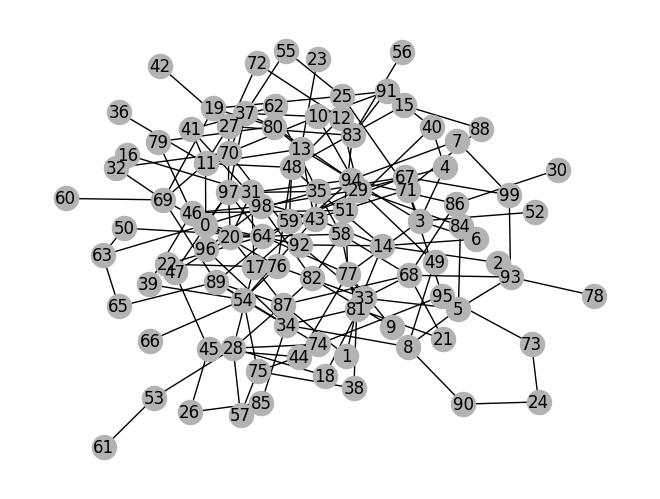

Running GNN...
Epoch: 0, Loss: 44.2684211730957
Epoch: 1000, Loss: 16.770076751708984
Epoch: 2000, Loss: 5.100363254547119
Epoch: 3000, Loss: 1.3506865501403809
Epoch: 4000, Loss: -0.5504041314125061
Epoch: 5000, Loss: -3.9808764457702637
Epoch: 6000, Loss: -12.856484413146973
Epoch: 7000, Loss: -23.302047729492188
Epoch: 8000, Loss: -32.84355163574219
Epoch: 9000, Loss: -38.91011428833008
Epoch: 10000, Loss: -41.56052780151367
Epoch: 11000, Loss: -42.455657958984375
Epoch: 12000, Loss: -42.75361633300781
Stopping early on epoch 12990 (patience: 100)
GNN training (n=100) took 45.493
GNN final continuous loss: -42.876075744628906
GNN best continuous loss: -42.876075744628906
-----------------------------------------------------------------------------------
Calculating violations...
Independence number found by GNN is 43 with 0 violations
Took 45.499s, model training took 45.494s
-----------------------------------------------------------------------------------
Running built-in MIS sol

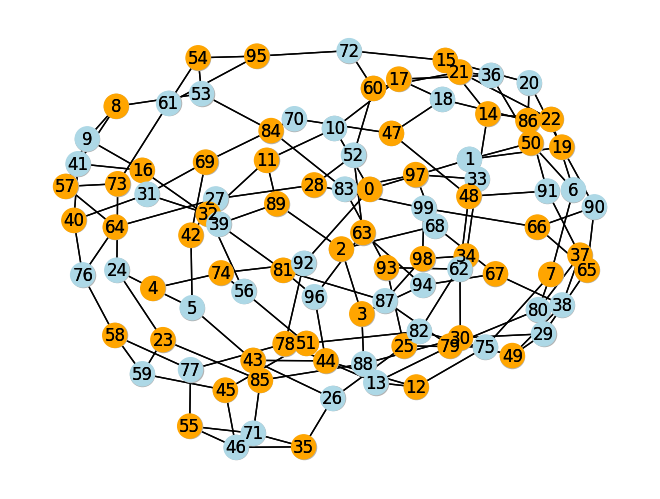

In [13]:
# Graph hypers
n = 100
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)

# Constructs a random graph of size n using my custom approach
nx_det_graph = gen_graph(n)

best_bitstring = run_network(nx_graph)

In [18]:
# Function that converts binary representation to NetworkX usable indexes
def getNodeIndexs(individual):
    nodes = []
    i = 0
    for bit in individual:        
        if bit==1:
            nodes.append(i)
        i += 1
        
    return nodes

#Create function to check if an individual represents an independent set
def isIndSet(G, individual):
    #Get indexs of 1's from individual
    nodes = getNodeIndexs(individual)
    
    #Check if node set is independent
    for u in nodes:
        for v in nodes:
            if u != v and G.has_edge(u,v):
                return False, nodes
    return True, nodes  

In [21]:
is_ind_set, mis = isIndSet(nx_graph, best_bitstring.tolist())
print(is_ind_set)

True
